In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from modules.numeric import *

In [72]:
phi4 = Phi4()
L = 100

def chi(H, mu, nu):
    return mu*np.arctanh(H**nu)

def varphi(x, mu, nu):
    return mu*np.tanh(-x)**nu

def phi_dirichlet(x, H, mu=1):
    assert H > -1
    nu = np.sign(1 - abs(H))
    return mu*np.tanh(chi(H, mu, nu) - x)**nu

def init(x, v, H):
    return np.stack((
        phi_dirichlet(v*(-L - x), H, mu=-1) + phi_dirichlet(v*x, H, mu=-1) + 1,
        np.zeros(x.shape)
    ))

In [73]:
N = 2048
DX = L/(N - 1)
DT = 4e-2

dirichlet = Dirichlet(order=4)
reflective = Reflective(order=4)

collider = Wave(
    x_grid= (-L, 0, N), 
    dt= DT, 
    order= 4,
    y0= init,
    F= phi4.diff,
    boundaries= (dirichlet, dirichlet),
    integrator= 'rk4',
)

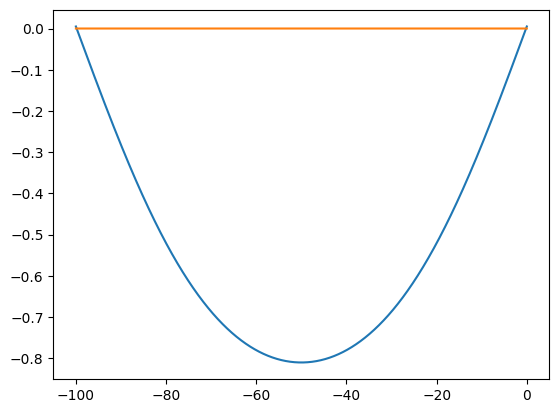

In [100]:
plt.plot(collider.x, init(collider.x, 0.03, 0).T)

In [101]:
H = 0
dirichlet.param = H
grid, Y = collider.run(300, v=0.03, H=H)
y, dydt = Y[:, 0], Y[:, 1]

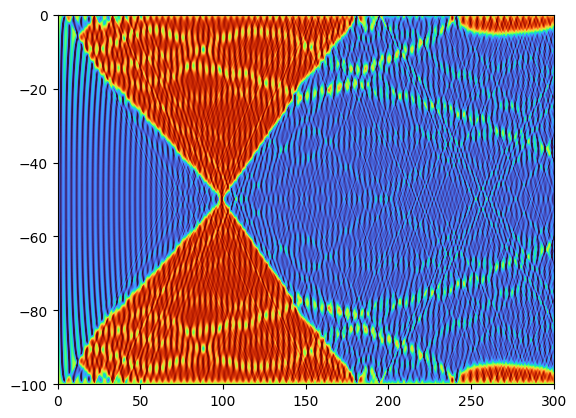

In [102]:
plt.imshow(y.T, cmap='turbo', vmin=-1.25, vmax=1.25, extent=grid.extent(), aspect='auto', origin='lower', interpolation='sinc')
# plt.ylim(-20, 0)